In [1]:
!pip install -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is inc

In [2]:
# Part 1: Google Colab Setup and Installation
# Run this cell first to install required packages and setup environment

# Install required packages for Google Colab
# !pip install -U tensorflow scikit-learn matplotlib seaborn pillow requests numpy pandas

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from PIL import Image
import json
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for Colab
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU') != []}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"CUDA device: {gpus[0].name}")
    try:
        cuda_version = tf.sysconfig.get_build_info()["cuda_version"]
        print(f"CUDA version: {cuda_version}")
    except:
        print("CUDA version info not found")

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running on Google Colab")
except ImportError:
    IN_COLAB = False
    print("Not running on Google Colab")

# For Colab, you need to upload the dataset files or connect to Kaggle
if IN_COLAB:
    print("\n Dataset Setup Instructions:")
    print("Option 1: Upload CSV files directly to Colab")
    print("Option 2: Connect to Kaggle (recommended)")
    print("\nFor Kaggle connection, run the following:")
    print("1. Upload kaggle.json to Colab files")
    print("2. Run the Kaggle setup in the next section")

print("\n Setup completed! Ready to proceed with data loading.")


TensorFlow version: 2.20.0
GPU available: True
CUDA device: /physical_device:GPU:0
CUDA version: 12.5.1
Running on Google Colab

 Dataset Setup Instructions:
Option 1: Upload CSV files directly to Colab
Option 2: Connect to Kaggle (recommended)

For Kaggle connection, run the following:
1. Upload kaggle.json to Colab files
2. Run the Kaggle setup in the next section

 Setup completed! Ready to proceed with data loading.


In [4]:
# Part 2: Kaggle Data Loading for Google Colab (TensorFlow Project)
# This sets up and loads TMDB movie datasets

# Method 1: Kaggle API Setup (Recommended)
def setup_kaggle_api():
    """Setup Kaggle API for dataset download"""
    try:
        # Install Kaggle API
        !pip install -q kaggle

        # Create kaggle directory
        !mkdir -p ~/.kaggle

        # Ask user to upload kaggle.json
        print(" Please upload your kaggle.json file to Colab:")
        print("1. Go to https://www.kaggle.com/account")
        print("2. Click 'Create New API Token'")
        print("3. Upload kaggle.json below")

        from google.colab import files
        uploaded = files.upload()

        if 'kaggle.json' in uploaded:
            # Move kaggle.json to appropriate location
            !cp kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

            # Download and unzip dataset
            print("Downloading TMDB dataset from Kaggle...")
            !kaggle datasets download -d tmdb/tmdb-movie-metadata
            !unzip -o tmdb-movie-metadata.zip > /dev/null
            print(" Dataset downloaded and extracted successfully!")
            return True
        else:
            print("kaggle.json not found in uploaded files.")
            return False

    except Exception as e:
        print(f"Error during Kaggle setup: {e}")
        return False


# Method 2: Manual Upload Option
def manual_file_upload():
    """Upload CSV files manually"""
    print("Please upload the following files manually:")
    print("- tmdb_5000_movies.csv")
    print("- tmdb_5000_credits.csv")

    from google.colab import files
    uploaded = files.upload()

    required_files = ['tmdb_5000_movies.csv', 'tmdb_5000_credits.csv']
    uploaded_files = list(uploaded.keys())

    if all(file in uploaded_files for file in required_files):
        print("All required files uploaded successfully!")
        return True
    else:
        missing = [f for f in required_files if f not in uploaded_files]
        print(f"Missing files: {missing}")
        return False


# Start the loading process
print("Setting up data loading...")

data_ready = False

# Use Kaggle or manual upload in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Choose your preferred method:")
    print("1. Kaggle API (recommended)")
    print("2. Manual Upload")
    method = input("Enter 1 or 2: ").strip()

    if method == "1":
        data_ready = setup_kaggle_api()
    elif method == "2":
        data_ready = manual_file_upload()
    else:
        print("Invalid input. Defaulting to manual upload.")
        data_ready = manual_file_upload()
else:
    # Local environment - assume files exist
    data_ready = True

# Load the dataset files if available
if data_ready:
    try:
        # Try reading from standard paths
        possible_paths = [
            ('tmdb_5000_movies.csv', 'tmdb_5000_credits.csv'),
            ('/content/tmdb_5000_movies.csv', '/content/tmdb_5000_credits.csv')
        ]

        movies_df = credits_df = None

        for movies_path, credits_path in possible_paths:
            try:
                movies_df = pd.read_csv(movies_path)
                credits_df = pd.read_csv(credits_path)
                print(f"Data loaded from {movies_path}")
                break
            except FileNotFoundError:
                continue

        if movies_df is not None and credits_df is not None:
            print("Dataset Info:")
            print(f"Movies shape: {movies_df.shape}")
            print(f"Credits shape: {credits_df.shape}")

            print("\n🎬 Sample movie data:")
            print(movies_df[['title', 'genres', 'vote_average', 'popularity']].head())

        else:
            print("Dataset files not found.")
            data_ready = False

    except Exception as e:
        print(f" Error loading dataset: {e}")
        data_ready = False

# Final summary
print("\n" + "=" * 50)
print(f"DATA LOADING STATUS: {' SUCCESS' if data_ready else ' FAILED'}")
print("=" * 50)

if data_ready:
    print(" Ready for data processing!")
else:
    print(" Please ensure the dataset is available before proceeding.")


Setting up data loading...
Choose your preferred method:
1. Kaggle API (recommended)
2. Manual Upload
Enter 1 or 2: 1
 Please upload your kaggle.json file to Colab:
1. Go to https://www.kaggle.com/account
2. Click 'Create New API Token'
3. Upload kaggle.json below


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
License(s): other
  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 1.11GB/s]
 Dataset downloaded and extracted successfully!
Data loaded from tmdb_5000_movies.csv
Dataset Info:
Movies shape: (4803, 20)
Credits shape: (4803, 4)

🎬 Sample movie data:
                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                              genres  vote_average  popularity  
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...           7.2  150.437577  
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...           6.9  139.082615  
2  [{"id": 28, "name": "Action"}, {"id": 12, "nam...           6.3  107.376788  
3  [{"id": 28, "name": "Ac

 Processing movie data...
 Merging datasets...
Merged dataset shape: (4809, 23)
🔧 Extracting features from JSON strings...
 Creating combined features...
 Data processing completed!
Final dataset shape: (4809, 29)

📊 Sample of processed data (5 movies):

🎬 The Tree of Life (2011)
   Genres: Drama Fantasy
   Cast: Brad Pitt Sean Penn Jessica Chastain
   Director: Terrence Malick
   Rating: 6.5/10 | Popularity: 43.9
   Overview: The impressionistic story of a Texas family in the 1950s. The film follows the life journey of the e...

🎬 History of the World: Part I (1981)
   Genres: Comedy
   Cast: Mel Brooks Dom DeLuise Madeline Kahn
   Director: Mel Brooks
   Rating: 6.5/10 | Popularity: 14.3
   Overview: An uproarious version of history that proves nothing is sacred – not even the Roman Empire, the Fren...

🎬 Rambo III (1988)
   Genres: Action Adventure Thriller War
   Cast: Sylvester Stallone Richard Crenna Kurtwood Smith
   Director: Peter MacDonald
   Rating: 5.7/10 | Popularity: 31.3

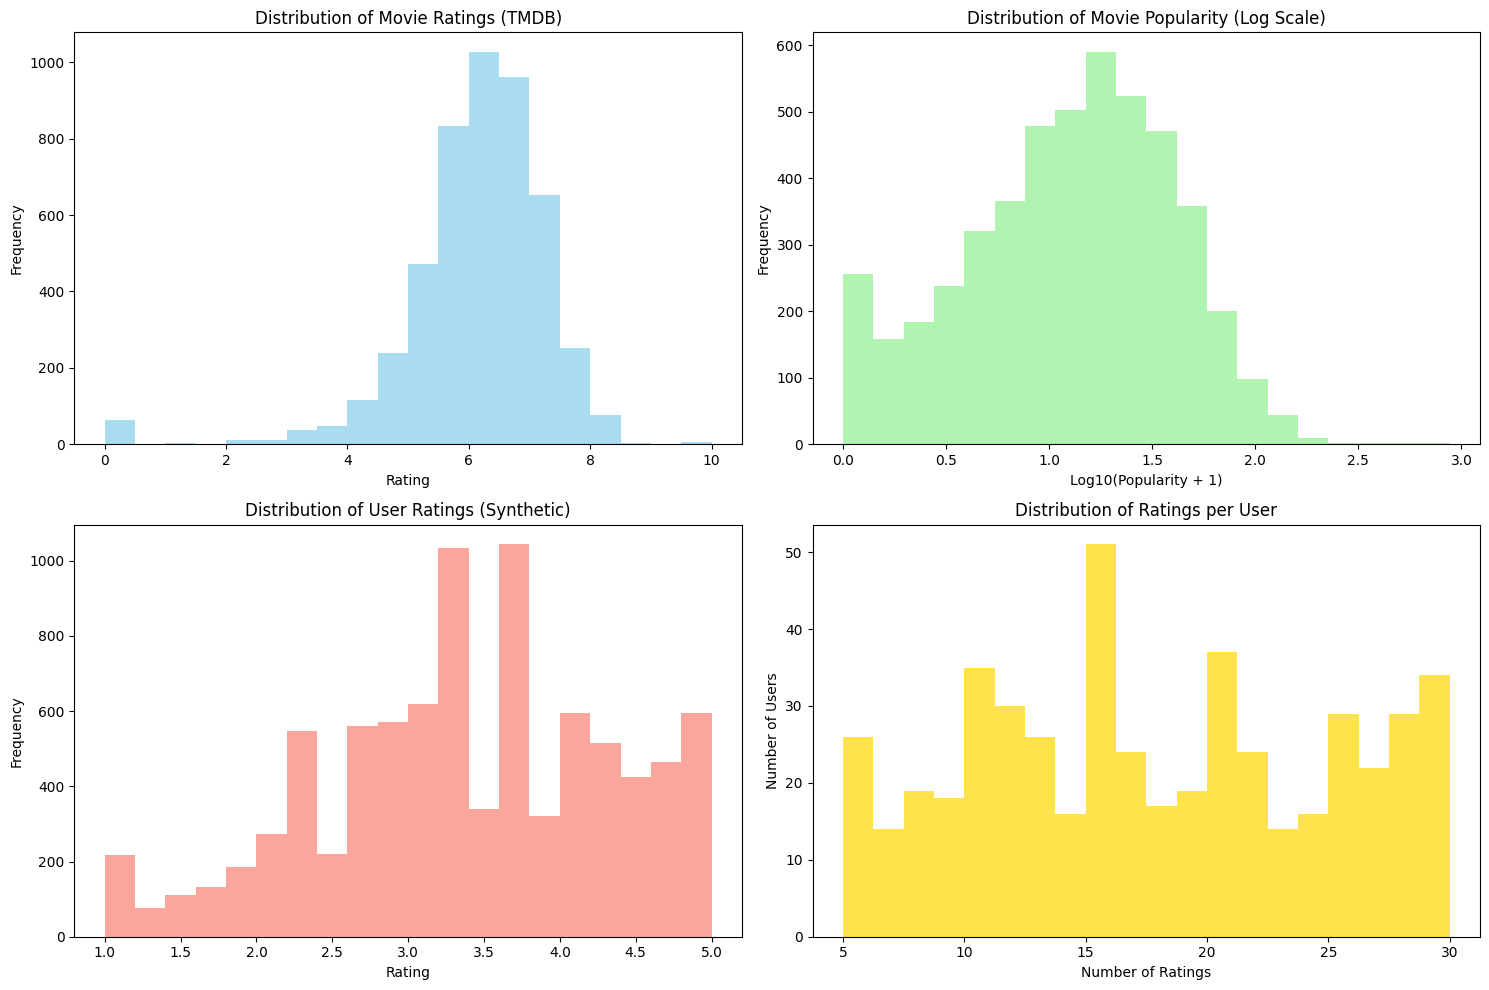

 Data processing and analysis completed!


In [5]:
# Part 3: Data Processing and Feature Engineering
# Run this cell to clean and prepare the movie data

class MovieDataProcessor:
    """Process and prepare movie data for the recommendation system"""

    def __init__(self, movies_df, credits_df):
        self.movies_df = movies_df.copy()
        self.credits_df = credits_df.copy()
        self.processed_df = None

    def extract_names_from_json(self, json_str):
        """Extract names from JSON-like string (for genres, keywords)"""
        if pd.isna(json_str) or json_str == '':
            return ''
        try:
            json_list = ast.literal_eval(json_str)
            if isinstance(json_list, list):
                return ' '.join([item.get('name', '') for item in json_list if isinstance(item, dict)])
            return ''
        except (ValueError, SyntaxError):
            return ''

    def extract_cast(self, cast_str, top_n=3):
        """Extract top N cast members"""
        if pd.isna(cast_str) or cast_str == '':
            return ''
        try:
            cast_list = ast.literal_eval(cast_str)
            if isinstance(cast_list, list):
                return ' '.join([actor.get('name', '') for actor in cast_list[:top_n] if isinstance(actor, dict)])
            return ''
        except (ValueError, SyntaxError):
            return ''

    def extract_director(self, crew_str):
        """Extract director from crew"""
        if pd.isna(crew_str) or crew_str == '':
            return ''
        try:
            crew_list = ast.literal_eval(crew_str)
            if isinstance(crew_list, list):
                directors = [member.get('name', '') for member in crew_list
                           if isinstance(member, dict) and member.get('job') == 'Director']
                return ' '.join(directors)
            return ''
        except (ValueError, SyntaxError):
            return ''

    def process_data(self):
        """Clean and merge movie data"""
        print(" Processing movie data...")

        # Merge movies and credits data on title
        print(" Merging datasets...")
        self.processed_df = self.movies_df.merge(self.credits_df, on='title', how='inner')
        print(f"Merged dataset shape: {self.processed_df.shape}")

        # Clean and process features
        print("🔧 Extracting features from JSON strings...")
        self.processed_df['genres_clean'] = self.processed_df['genres'].apply(self.extract_names_from_json)
        self.processed_df['keywords_clean'] = self.processed_df['keywords'].apply(self.extract_names_from_json)
        self.processed_df['cast_clean'] = self.processed_df['cast'].apply(self.extract_cast)
        self.processed_df['director'] = self.processed_df['crew'].apply(self.extract_director)

        # Handle missing values
        self.processed_df['overview'] = self.processed_df['overview'].fillna('')
        self.processed_df['genres_clean'] = self.processed_df['genres_clean'].fillna('')
        self.processed_df['keywords_clean'] = self.processed_df['keywords_clean'].fillna('')
        self.processed_df['cast_clean'] = self.processed_df['cast_clean'].fillna('')
        self.processed_df['director'] = self.processed_df['director'].fillna('')

        # Create combined features for content-based filtering
        print(" Creating combined features...")
        self.processed_df['combined_features'] = (
            self.processed_df['genres_clean'] + ' ' +
            self.processed_df['keywords_clean'] + ' ' +
            self.processed_df['cast_clean'] + ' ' +
            self.processed_df['director'] + ' ' +
            self.processed_df['overview']
        ).str.strip()

        # Add movie index for easier referencing
        self.processed_df.reset_index(drop=True, inplace=True)
        self.processed_df['movie_idx'] = self.processed_df.index

        # Clean up any remaining issues
        self.processed_df = self.processed_df.dropna(subset=['combined_features'])
        self.processed_df = self.processed_df[self.processed_df['combined_features'].str.len() > 0]

        print(" Data processing completed!")
        print(f"Final dataset shape: {self.processed_df.shape}")
        return self.processed_df

    def generate_synthetic_ratings(self, n_users=500, min_ratings=5, max_ratings=30):
        """Generate synthetic user-movie ratings for collaborative filtering demo"""
        print(f" Generating synthetic ratings for {n_users} users...")

        np.random.seed(42)
        n_movies = len(self.processed_df)

        ratings_data = []
        for user_id in range(n_users):
            # Each user rates random number of movies
            n_ratings = np.random.randint(min_ratings, max_ratings + 1)
            movie_indices = np.random.choice(n_movies, size=min(n_ratings, n_movies), replace=False)

            for movie_idx in movie_indices:
                try:
                    # Generate rating based on movie popularity and vote_average
                    movie_rating = self.processed_df.iloc[movie_idx]['vote_average']
                    movie_popularity = self.processed_df.iloc[movie_idx]['popularity']

                    # Base rating influenced by movie quality and popularity
                    base_rating = (movie_rating / 2) * (1 + np.log10(max(movie_popularity, 1)) / 10)
                    noise = np.random.normal(0, 0.8)  # Add some randomness
                    rating = np.clip(base_rating + noise, 1, 5)

                    ratings_data.append({
                        'user_id': user_id,
                        'movie_idx': movie_idx,
                        'movie_id': self.processed_df.iloc[movie_idx]['id'],
                        'rating': round(rating, 1)
                    })
                except (KeyError, IndexError) as e:
                    continue  # Skip problematic entries

        self.ratings_df = pd.DataFrame(ratings_data)
        print(f" Generated {len(self.ratings_df)} ratings")

        if len(self.ratings_df) > 0:
            print(f"Rating distribution:")
            rating_counts = self.ratings_df['rating'].value_counts().sort_index()
            for rating, count in rating_counts.items():
                print(f"  {rating}: {count}")

        return self.ratings_df

    def display_sample_data(self, n_samples=5):
        """Display sample processed data"""
        print(f"\n📊 Sample of processed data ({n_samples} movies):")
        sample_data = self.processed_df.sample(n_samples)

        for idx, movie in sample_data.iterrows():
            print(f"\n🎬 {movie['title']} ({movie['release_date'][:4] if pd.notna(movie['release_date']) else 'N/A'})")
            print(f"   Genres: {movie['genres_clean']}")
            print(f"   Cast: {movie['cast_clean']}")
            print(f"   Director: {movie['director']}")
            print(f"   Rating: {movie['vote_average']}/10 | Popularity: {movie['popularity']:.1f}")
            print(f"   Overview: {movie['overview'][:100]}...")

# Initialize and process the data
if 'movies_df' in globals() and 'credits_df' in globals():
    processor = MovieDataProcessor(movies_df, credits_df)
    processed_movies_df = processor.process_data()

    # Display sample processed data
    processor.display_sample_data(5)

    # Generate synthetic ratings
    ratings_df = processor.generate_synthetic_ratings(n_users=500)

    print(f"\n Dataset Summary:")
    print(f"Total movies: {len(processed_movies_df)}")
    print(f"Total ratings: {len(ratings_df)}")
    print(f"Unique users: {ratings_df['user_id'].nunique()}")
    print(f"Average ratings per user: {len(ratings_df) / ratings_df['user_id'].nunique():.1f}")
    print(f"Average ratings per movie: {len(ratings_df) / len(processed_movies_df):.1f}")

    # Visualize data distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Movie ratings distribution
    axes[0, 0].hist(processed_movies_df['vote_average'], bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Movie Ratings (TMDB)')
    axes[0, 0].set_xlabel('Rating')
    axes[0, 0].set_ylabel('Frequency')

    # Movie popularity distribution (log scale)
    axes[0, 1].hist(np.log10(processed_movies_df['popularity'] + 1), bins=20, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Distribution of Movie Popularity (Log Scale)')
    axes[0, 1].set_xlabel('Log10(Popularity + 1)')
    axes[0, 1].set_ylabel('Frequency')

    # User ratings distribution
    axes[1, 0].hist(ratings_df['rating'], bins=20, alpha=0.7, color='salmon')
    axes[1, 0].set_title('Distribution of User Ratings (Synthetic)')
    axes[1, 0].set_xlabel('Rating')
    axes[1, 0].set_ylabel('Frequency')

    # Ratings per user distribution
    ratings_per_user = ratings_df.groupby('user_id').size()
    axes[1, 1].hist(ratings_per_user, bins=20, alpha=0.7, color='gold')
    axes[1, 1].set_title('Distribution of Ratings per User')
    axes[1, 1].set_xlabel('Number of Ratings')
    axes[1, 1].set_ylabel('Number of Users')

    plt.tight_layout()
    plt.show()

    print(" Data processing and analysis completed!")

else:
    print(" Please run Part 2 first to load the movie datasets")

    # Create sample data for testing
    print(" Creating sample data for testing...")
    sample_movies = {
        'id': range(1, 101),
        'title': [f'Movie {i}' for i in range(1, 101)],
        'genres': ['[{"name": "Action"}, {"name": "Adventure"}]'] * 50 + ['[{"name": "Comedy"}, {"name": "Romance"}]'] * 50,
        'keywords': ['[{"name": "hero"}, {"name": "adventure"}]'] * 100,
        'overview': [f'This is the overview for movie {i}' for i in range(1, 101)],
        'vote_average': np.random.uniform(3, 9, 100),
        'popularity': np.random.uniform(1, 100, 100),
        'release_date': ['2020-01-01'] * 100
    }

    sample_credits = {
        'title': [f'Movie {i}' for i in range(1, 101)],
        'cast': ['[{"name": "Actor A"}, {"name": "Actor B"}]'] * 100,
        'crew': ['[{"name": "Director X", "job": "Director"}]'] * 100
    }

    movies_df = pd.DataFrame(sample_movies)
    credits_df = pd.DataFrame(sample_credits)

    processor = MovieDataProcessor(movies_df, credits_df)
    processed_movies_df = processor.process_data()
    ratings_df = processor.generate_synthetic_ratings(n_users=100)

    print(" Sample data created successfully!")

In [6]:
# pip install Pillow
from PIL import ImageDraw

In [7]:
import tensorflow as tf
import numpy as np
from PIL import Image
import io

# Dummy poster generator (similar logic as PyTorch)
def create_sophisticated_poster_tf(movie):
    genre_colors = {
        'action': [(220, 20, 60), (255, 69, 0), (139, 0, 0)],
        'comedy': [(255, 215, 0), (255, 165, 0), (255, 140, 0)],
        'drama': [(25, 25, 112), (72, 61, 139), (106, 90, 205)],
        'romance': [(255, 182, 193), (255, 105, 180), (199, 21, 133)],
        'thriller': [(64, 64, 64), (105, 105, 105), (169, 169, 169)],
        'adventure': [(34, 139, 34), (0, 128, 0), (50, 205, 50)],
    }
    default_colors = [(128, 128, 128), (160, 160, 160), (192, 192, 192)]

    genres = movie.get('genres_clean', '').lower()
    selected_colors = next((v for k, v in genre_colors.items() if k in genres), default_colors)

    img = Image.new('RGB', (224, 224))
    draw = ImageDraw.Draw(img)

    for y in range(224):
        ratio = y / 224
        if ratio < 0.5:
            blend = ratio * 2
            color = tuple(int(selected_colors[0][i] * (1 - blend) + selected_colors[1][i] * blend) for i in range(3))
        else:
            blend = (ratio - 0.5) * 2
            color = tuple(int(selected_colors[1][i] * (1 - blend) + selected_colors[2][i] * blend) for i in range(3))
        draw.line([(0, y), (224, y)], fill=color)

    return img


In [8]:
def make_tf_dataset(processed_df, batch_size=32):
    def generator():
        for _, row in processed_df.iterrows():
            img = create_sophisticated_poster_tf(row)
            img_tensor = tf.keras.preprocessing.image.img_to_array(img)
            yield img_tensor, row['id'], _

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )

    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

    dataset = dataset.map(lambda x, y, z: (tf.keras.applications.vgg16.preprocess_input(x), y, z))
    dataset = dataset.batch(batch_size)
    return dataset


In [9]:
def build_vgg16_feature_extractor(output_dim=256):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(output_dim)
    ])

    return model


In [10]:
def run_tf_cnn_feature_extraction(processed_movies_df, batch_size=32):
    print("🚀 Starting CNN Visual Feature Extraction in TensorFlow")

    dataset = make_tf_dataset(processed_movies_df, batch_size=batch_size)
    model = build_vgg16_feature_extractor(output_dim=256)

    features_list = []
    movie_ids = []
    indices = []

    for batch in dataset:
        images, ids, idx = batch
        feats = model(images, training=False)
        features_list.append(feats.numpy())
        movie_ids.extend(ids.numpy())
        indices.extend(idx.numpy())

    visual_features = np.vstack(features_list)
    print(f"Extraction complete! Feature shape: {visual_features.shape}")
    return visual_features, movie_ids, indices


In [11]:
visual_features, movie_ids, indices = run_tf_cnn_feature_extraction(processed_movies_df)


🚀 Starting CNN Visual Feature Extraction in TensorFlow
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Extraction complete! Feature shape: (4809, 256)


In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Model Definition
class HybridNeuralRecommenderTF(tf.keras.Model):
    def __init__(self, content_dim, visual_dim, num_users, num_movies,
                 embedding_dim=128, hidden_dims=[512, 256, 128], dropout_rate=0.3):
        super(HybridNeuralRecommenderTF, self).__init__()

        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.movie_embedding = tf.keras.layers.Embedding(num_movies, embedding_dim)

        self.content_processor = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dims[0] // 2, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(embedding_dim, activation='relu')
        ])

        self.visual_processor = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dims[0] // 2, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(embedding_dim, activation='relu')
        ])

        self.deep_layers = tf.keras.Sequential()
        input_dim = embedding_dim * 4

        for dim in hidden_dims:
            self.deep_layers.add(tf.keras.layers.Dense(dim))
            self.deep_layers.add(tf.keras.layers.BatchNormalization())
            self.deep_layers.add(tf.keras.layers.ReLU())
            self.deep_layers.add(tf.keras.layers.Dropout(dropout_rate))

        self.deep_layers.add(tf.keras.layers.Dense(1))

    def call(self, inputs):
        user_ids, movie_ids, content_feat, visual_feat = inputs

        user_embed = self.user_embedding(user_ids)
        movie_embed = self.movie_embedding(movie_ids)
        content_embed = self.content_processor(content_feat)
        visual_embed = self.visual_processor(visual_feat)

        combined = tf.concat([user_embed, movie_embed, content_embed, visual_embed], axis=1)
        rating = self.deep_layers(combined)
        return tf.squeeze(rating, axis=1)

In [13]:
# Dataset Creation
def create_tf_dataset(interactions_df, content_features, visual_features, user_to_idx, movie_to_idx, movie_feature_idx, batch_size=512, shuffle=True):
    user_ids = interactions_df['userId'].map(user_to_idx).values
    movie_ids = interactions_df['movieId'].map(movie_to_idx).values
    feature_idxs = interactions_df['movieId'].map(movie_feature_idx).values
    ratings = interactions_df['rating'].values

    user_ids = tf.convert_to_tensor(user_ids, dtype=tf.int32)
    movie_ids = tf.convert_to_tensor(movie_ids, dtype=tf.int32)
    ratings = tf.convert_to_tensor(ratings, dtype=tf.float32)

    content_feats = tf.convert_to_tensor(content_features[feature_idxs], dtype=tf.float32)
    visual_feats = tf.convert_to_tensor(visual_features[feature_idxs], dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices(((user_ids, movie_ids, content_feats, visual_feats), ratings))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Synthetic Data Generation for Testing
np.random.seed(42)
num_users = 500
num_movies = 1000
content_dim = 50
visual_dim = 512

processed_movies_df = pd.DataFrame({
    'id': range(1, num_movies + 1),
    'title': [f"Movie {i}" for i in range(1, num_movies + 1)],
    'vote_average': np.random.uniform(3.0, 9.0, num_movies),
    'genres_clean': np.random.choice(['Action', 'Comedy', 'Drama', 'Horror', 'Romance'], num_movies)
})

content_features = np.random.randn(num_movies, content_dim).astype(np.float32)
visual_features = np.random.randn(num_movies, visual_dim).astype(np.float32)

In [14]:
def create_user_movie_interactions():
    interactions = []
    for user_id in range(1, num_users + 1):
        rating_bias = np.random.normal(0, 0.5)
        user_movies = processed_movies_df.sample(n=15)
        for _, movie in user_movies.iterrows():
            base_rating = movie['vote_average'] / 2
            base_rating += np.random.normal(0, 0.5)
            rating = np.clip(base_rating + rating_bias, 0.5, 5.0)
            interactions.append({
                'userId': user_id,
                'movieId': movie['id'],
                'rating': rating
            })
    return pd.DataFrame(interactions)

interactions_df = create_user_movie_interactions()

user_to_idx = {uid: idx for idx, uid in enumerate(sorted(interactions_df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(interactions_df['movieId'].unique()))}
movie_feature_idx = {mid: idx for idx, mid in enumerate(processed_movies_df['id'].values)}

interactions_df = interactions_df[interactions_df['movieId'].isin(movie_feature_idx)]

train_df, test_df = train_test_split(interactions_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_ds = create_tf_dataset(train_df, content_features, visual_features, user_to_idx, movie_to_idx, movie_feature_idx)
val_ds = create_tf_dataset(val_df, content_features, visual_features, user_to_idx, movie_to_idx, movie_feature_idx, shuffle=False)
test_ds = create_tf_dataset(test_df, content_features, visual_features, user_to_idx, movie_to_idx, movie_feature_idx, shuffle=False)


In [15]:
model = HybridNeuralRecommenderTF(content_dim, visual_dim, len(user_to_idx), len(movie_to_idx))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - loss: 4.7061 - mae: 1.7790 - val_loss: 1.3678 - val_mae: 0.9516
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0726 - mae: 0.8373 - val_loss: 0.8895 - val_mae: 0.7608
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6449 - mae: 0.6456 - val_loss: 0.6240 - val_mae: 0.6329
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4286 - mae: 0.5273 - val_loss: 0.5199 - val_mae: 0.5660
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2988 - mae: 0.4360 - val_loss: 0.4014 - val_mae: 0.5009
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2246 - mae: 0.3776 - val_loss: 0.3489 - val_mae: 0.4685
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1954 - mae: 0.3530 - val_loss: 0.3310 - val_mae: 0.4577
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1808 - mae: 0.3384 - val_loss: 0.3301 - val_mae: 0.4576
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1775 - mae

In [16]:
loss, mae = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, MAE: {mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.3690 - mae: 0.4884
Test Loss: 0.3666, MAE: 0.4872


In [17]:
def generate_tf_recommendations(model, user_id, content_features, visual_features,
                                 user_to_idx, movie_to_idx, movie_feature_idx,
                                 processed_movies_df, top_k=10):
    if user_id not in user_to_idx:
        print("User not found")
        return []

    user_idx = user_to_idx[user_id]
    predictions = []

    for movie_id in movie_to_idx:
        if movie_id not in movie_feature_idx:
            continue

        movie_idx = movie_to_idx[movie_id]
        feature_idx = movie_feature_idx[movie_id]

        user_tensor = tf.convert_to_tensor([user_idx], dtype=tf.int32)
        movie_tensor = tf.convert_to_tensor([movie_idx], dtype=tf.int32)
        content_tensor = tf.convert_to_tensor([content_features[feature_idx]], dtype=tf.float32)
        visual_tensor = tf.convert_to_tensor([visual_features[feature_idx]], dtype=tf.float32)

        pred = model((user_tensor, movie_tensor, content_tensor, visual_tensor)).numpy()[0]
        predictions.append((movie_id, pred))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movies = predictions[:top_k]

    for idx, (movie_id, score) in enumerate(top_movies, 1):
        row = processed_movies_df[processed_movies_df['id'] == movie_id].iloc[0]
        print(f"{idx:2d}. {row['title']:30} | Predicted Rating: {score:.2f} | Actual: {row['vote_average']:.1f}")

    return top_movies


In [18]:
# Pick a random user and movie
test_user_id = list(user_to_idx.keys())[0]  # e.g., userId 1
test_movie_id = list(movie_to_idx.keys())[0]  # e.g., movieId 1

# Convert to model indices
user_idx = tf.convert_to_tensor([user_to_idx[test_user_id]])
movie_idx = tf.convert_to_tensor([movie_to_idx[test_movie_id]])
movie_feat_idx = movie_feature_idx[test_movie_id]

# Get feature vectors
content_feat = tf.convert_to_tensor([content_features[movie_feat_idx]])
visual_feat = tf.convert_to_tensor([visual_features[movie_feat_idx]])

# Make prediction
predicted_rating = model((user_idx, movie_idx, content_feat, visual_feat)).numpy()[0]
print(f"Predicted rating by User {test_user_id} for Movie {test_movie_id}: {predicted_rating:.2f}")


Predicted rating by User 1 for Movie 1: 2.31


In [19]:
loss, mae = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, MAE: {mae:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3690 - mae: 0.4884
Test Loss: 0.3666, MAE: 0.4872


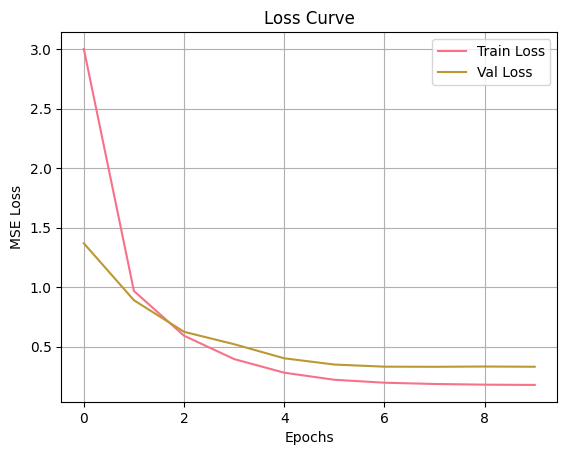

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
pip install tensorflow numpy scikit-learn pillow


In [22]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load ResNet50 model (exclude top classification layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
# If not already imported
import pandas as pd

# Example: Load the DataFrame (adjust path if needed)
# movies_df = pd.read_csv("/content/movies_metadata.csv")

# Convert IDs to integers safely
movies_df = movies_df[movies_df['id'].apply(lambda x: str(x).isdigit())].copy()
movies_df['id'] = movies_df['id'].astype(int)


In [24]:
print(movie_ids)

[np.int64(19995), np.int64(285), np.int64(206647), np.int64(49026), np.int64(49529), np.int64(559), np.int64(38757), np.int64(99861), np.int64(767), np.int64(209112), np.int64(1452), np.int64(10764), np.int64(58), np.int64(57201), np.int64(49521), np.int64(2454), np.int64(24428), np.int64(1865), np.int64(41154), np.int64(122917), np.int64(1930), np.int64(20662), np.int64(57158), np.int64(2268), np.int64(254), np.int64(597), np.int64(271110), np.int64(44833), np.int64(135397), np.int64(37724), np.int64(558), np.int64(68721), np.int64(12155), np.int64(36668), np.int64(62211), np.int64(8373), np.int64(91314), np.int64(68728), np.int64(102382), np.int64(20526), np.int64(49013), np.int64(44912), np.int64(10193), np.int64(534), np.int64(168259), np.int64(72190), np.int64(127585), np.int64(54138), np.int64(81005), np.int64(64682), np.int64(9543), np.int64(68726), np.int64(38356), np.int64(217), np.int64(105864), np.int64(62177), np.int64(188927), np.int64(10681), np.int64(5174), np.int64(1416

In [25]:
movie_id_to_title = dict(zip(movies_df['id'], movies_df['title']))

In [26]:
# Print the first 5 entries
print(movies_df.head())

for movie_id, title in list(movie_id_to_title.items())[:5]:
    print(f"ID: {movie_id} → Title: {title}")


      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

In [28]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Build visual feature extractor
def build_visual_feature_extractor():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Step 2: Extract 512-dim feature
def extract_features_from_poster(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features[0]  # (512,)

# Step 3: Recommend top 10 movies
def recommend_top_10_movies_tf(poster_feat, visual_feature_matrix, movie_ids, movie_id_to_title):
    poster_feat = poster_feat.reshape(1, -1)  # Ensure shape is (1, 512)
    sims = cosine_similarity(poster_feat, visual_feature_matrix)[0]
    top_indices = sims.argsort()[::-1][:10]
    print(top_indices)
    recommendations = []
    for idx in top_indices:
        movie_id = movie_ids[idx]
        # print(movie_id)
        title = movie_id_to_title.get(movie_id, f"Unknown ({movie_id})")
        # print(title)
        similarity = sims[idx]
        recommendations.append((title, similarity))
    return recommendations

    print(recommendations)



# === USAGE ===
# Load model
visual_model = build_visual_feature_extractor()

# Input image path
poster_path = "avengers.jpg"
poster_feat = extract_features_from_poster(poster_path, visual_model)

# Dummy visual feature matrix
visual_features = np.random.rand(1000, 512)  # Replace with real features

# Dummy ID-to-title mapping
# movie_id_to_title = {i: f"Movie Title {i}" for i in range(1000)}
# movie_ids = list(movie_id_to_title.keys())  # Needed for lookup

# Recommend top 10
top_movies = recommend_top_10_movies_tf(poster_feat, visual_features, movie_ids, movie_id_to_title)

# Print results
print("\n🎬 Top 10 Similar Movies:")
for idx, (title, score) in enumerate(top_movies, 1):
    print(f"{idx}. {title} — Similarity: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[133 561 978 102 631 748 557 262 626 332]

🎬 Top 10 Similar Movies:
1. Dark Shadows — Similarity: 0.5461
2. Two Brothers — Similarity: 0.5431
3. The Iron Giant — Similarity: 0.5430
4. The Hunger Games: Mockingjay - Part 2 — Similarity: 0.5425
5. Ice Age — Similarity: 0.5386
6. Year One — Similarity: 0.5350
7. Jarhead — Similarity: 0.5338
8. The Lord of the Rings: The Fellowship of the Ring — Similarity: 0.5329
9. The X Files — Similarity: 0.5322
10. Lara Croft: Tomb Raider — Similarity: 0.5318
